Lauri Maila <br>
Student number 2209361 <br>
February, 6, 2024  <br>

# Exercise 2 | TKO_7092 Evaluation of Machine Learning Methods 2024

### Prediction of the metal ion content from multi-parameter data
<b> Use K-Nearest Neighbor Regression with euclidean distance to predict total metal concentration (c_total), concentration of Cadmium (Cd) and concentration of Lead (Pb), using number of neighbors k = 1, 3, 5, 7.</b> <br>

<b> Instructions: </b> 

    - You may use Nearest Neighbor Regression from https://scikit-learn.org/stable/modules/neighbors.html
    - The data should be standarized using z-score (using sklearn.preprocessing.StandardScaler is advised).
    - Implement Leave-One-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb). 
    - Implement Leave-Replicas-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb).
    - Explain your code by adding detailed comments. 
    - Only provide code that is relevant to the exercise.
    - Please submit your solution as a Jupyter Notebook (.ipynb) and as a PDF file. Ensure to include your full name in the filename.     
    - Submit to moodle your solution on ** Wednesday 7 of February ** at the latest.
  
<b>Please follow the instructions and note that you are expected to submit your individual solution.<br>
Identical or overly similar submissions will result in the exercise being marked as failed.
</b>

## Import libraries

In [74]:
# In this cell import all libraries you need. For example: 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, LeaveOneGroupOut
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

## Read and visualize the dataset

In [75]:
# In this cell read the file Water_data.csv
waterdata_df = pd.read_csv('water_data.csv')
dim = waterdata_df.shape
print("Number of rows:", dim[0])
print("Number of columns:", dim[1])
waterdata_df.head()

Number of rows: 268
Number of columns: 6


,Mod1,Mod2,Mod3,c_total,Cd,Pb
0,9945,119,72335,0,0.0,0.0
1,9596,119,110542,0,0.0,0.0
2,10812,120,98594,0,0.0,0.0
3,10786,117,82977,0,0.0,0.0
4,10566,108,136416,14,0.0,14.0


## Standardization of the dataset

In [76]:
# In this cell, standardize the dataset features by removing the mean and scaling to unit variance. 
# In other words, use z-score to scale the dataset features (Mod1, Mod2, Mod3) 
# Print the 5 first samples (i.e. rows) of the scaled dataset

# I'll use sklearn StandardScaler to scale the features Mod1, Mod2 and Mod3
scaler = StandardScaler()

# Fit and transform the chosen features
scaled_features = scaler.fit_transform(waterdata_df[['Mod1', 'Mod2', 'Mod3']])

# Create a fd with the scaled features
scaled_features_df = pd.DataFrame(scaled_features, columns=['Mod1', 'Mod2', 'Mod3'])

# Print the first 5 samples of the scaled dataset
scaled_features_df.head()

,Mod1,Mod2,Mod3
0,-0.972283,-0.670482,-0.358179
1,-0.975878,-0.670482,0.259488
2,-0.963351,-0.670394,0.066333
3,-0.963619,-0.670657,-0.186137
4,-0.965885,-0.671447,0.677776


## C-index code 

In [77]:
# I'm using the same C-index implementation given in the first exercise
"""
C-index function: 
- INPUTS: 
'y' an array of the true output values
'yp' an array of predicted output values
- OUTPUT: 
The c-index value
"""
def cindex(y, yp):
    n = 0
    h_num = 0 
    for i in range(0, len(y)):
        t = y[i]
        p = yp[i]
        for j in range(i+1, len(y)):
            nt = y[j]
            np = yp[j]
            if (t != nt): 
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt): 
                    h_num += 1
                elif (p == np):
                    h_num += 0.5
    return h_num/n

In [78]:
# Test the cindex function with following values
true_labels = np.array([-1, 1, 1, -1, 1])
predictions = np.array([0.60, 0.80, 0.75, 0.75, 0.70])
cindx = cindex(true_labels, predictions)
print(cindx) # This shoudl give 0.75, works fine

0.75


## Leave-One-Out cross-validation
In the following cell, write and execute your code for Leave-One-Out cross-validation using K-Nearest Neighbor Regression with k values of 1, 3, 5, and 7.<br>
Print the corresponding Leave-One-Out C-index for c_total, Cd and Pb for each k value.

In [79]:
# We'll use the scaled features for X data
X = scaled_features_df[['Mod1', 'Mod2', 'Mod3']]
y = waterdata_df[['c_total', 'Cd', 'Pb']]

# K-values to test
k_values = [1, 3, 5, 7]

# Dict for the results for plotting at the end
results_dict = []

# Iterate for each target variable c_total, Cd and Pb
for target_col in y.columns:
    print(f"Target variable: {target_col}")
    # Iterate for each k-value for the kNN
    for k in k_values:
        # Using LeaveOneOut() to get LOOCV indices
        loocv = LeaveOneOut()

        # Lists to store the predictions and actual values for C-index calculation
        predictions = []
        true_values = []
        
        # Split the data using LOOCV
        for train_index, test_index in loocv.split(X):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            # Separate for each variable
            y_train, y_test = y[target_col].iloc[train_index], y[target_col].iloc[test_index]
            
            # Initialize the kNN model
            knn = KNeighborsRegressor(n_neighbors=k)
            knn.fit(X_train, y_train)
            
            # Predict on the single test data using previously trained model
            y_pred = knn.predict(X_test)
            predictions.append(y_pred.tolist())
            true_values.append(y_test.values.tolist())

        # Calculate the C-index for the current k-value/variable and store it
        loocv_cindex = cindex(np.array(true_values), np.array(predictions))
        results_dict.append({'type': 'loocv', 'variable': target_col, 'k': k, 'cindex': loocv_cindex})

        print(f"K = {k}: Leave-One-Out C-index: {loocv_cindex:.3f}")

Target variable: c_total


K = 1: Leave-One-Out C-index: 0.908
K = 3: Leave-One-Out C-index: 0.920
K = 5: Leave-One-Out C-index: 0.896
K = 7: Leave-One-Out C-index: 0.884
Target variable: Cd
K = 1: Leave-One-Out C-index: 0.914
K = 3: Leave-One-Out C-index: 0.912
K = 5: Leave-One-Out C-index: 0.866
K = 7: Leave-One-Out C-index: 0.832
Target variable: Pb
K = 1: Leave-One-Out C-index: 0.880
K = 3: Leave-One-Out C-index: 0.885
K = 5: Leave-One-Out C-index: 0.861
K = 7: Leave-One-Out C-index: 0.841


## Leave-Replicas-Out cross-validation

In the following cell, write and execute your code for Leave-Replicas-Out cross-validation using K-Nearest Neighbor Regression with k values of 1, 3, 5, and 7.<br>
Print the corresponding Leave-Replicas-Out C-index for c_total, Cd and Pb for each k value.

In [80]:
# Create the replica groups for Leave-Replicas-Out CV
def create_replica_groups(data):
    # Get unique rows and their counts
    _, idx, counts = np.unique(data, return_index=True, return_counts=True, axis=0)
    groups = np.repeat(np.arange(len(counts)), counts)
    return groups

# Group labels based on replicas for each target variable
groups = {}
for target_col in y.columns:
    # Create replica groups for each variable
    groups[target_col] = create_replica_groups(y[target_col].to_numpy())

# K-values to test
k_values = [1, 3, 5, 7]

# Iterate for each target variable c_total, Cd and Pb
for target_col in y.columns:
    print(f"Target variable: {target_col}")
    # Iterate for each k-value for the kNN
    for k in k_values:
        # Using LeaveOneGroupOut() to get CV indices based on replica groups
        lro = LeaveOneGroupOut()

        # Lists to store the predictions and actual values for C-index calculation
        predictions = []
        true_values = []
        
        # Split the data using Leave-Replicas-Out CV
        for train_index, test_index in lro.split(X, groups=groups[target_col]): # Use groups for correct variable
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[target_col].iloc[train_index], y[target_col].iloc[test_index]
            
            # Initialize the kNN model
            knn = KNeighborsRegressor(n_neighbors=k)
            knn.fit(X_train, y_train)
            
            # Predict on the left out group data using previously trained model
            y_pred = knn.predict(X_test)
            predictions.extend(y_pred.tolist())
            true_values.extend(y_test.values.tolist())

        # Calculate the C-index for the current k-value/variable and store it
        lro_cindex = cindex(np.array(true_values), np.array(predictions))
        res = {'type': 'lro', 'variable': target_col, 'k': k, 'cindex': lro_cindex}
        results_dict.append(res)

        print(f"K = {k}: Leave-Replicas-Out C-index: {lro_cindex:.3f}")

Target variable: c_total
K = 1: Leave-Replicas-Out C-index: 0.786
K = 3: Leave-Replicas-Out C-index: 0.776
K = 5: Leave-Replicas-Out C-index: 0.773
K = 7: Leave-Replicas-Out C-index: 0.781
Target variable: Cd
K = 1: Leave-Replicas-Out C-index: 0.697
K = 3: Leave-Replicas-Out C-index: 0.693
K = 5: Leave-Replicas-Out C-index: 0.678
K = 7: Leave-Replicas-Out C-index: 0.673
Target variable: Pb
K = 1: Leave-Replicas-Out C-index: 0.744
K = 3: Leave-Replicas-Out C-index: 0.758
K = 5: Leave-Replicas-Out C-index: 0.751
K = 7: Leave-Replicas-Out C-index: 0.752


## Plot Leave-One-Out and Leave-Replicas-Out Results

Note: You may plot the results as they were presented in the video lecture (refer to MOOC2-Module 2 .pptx slides).

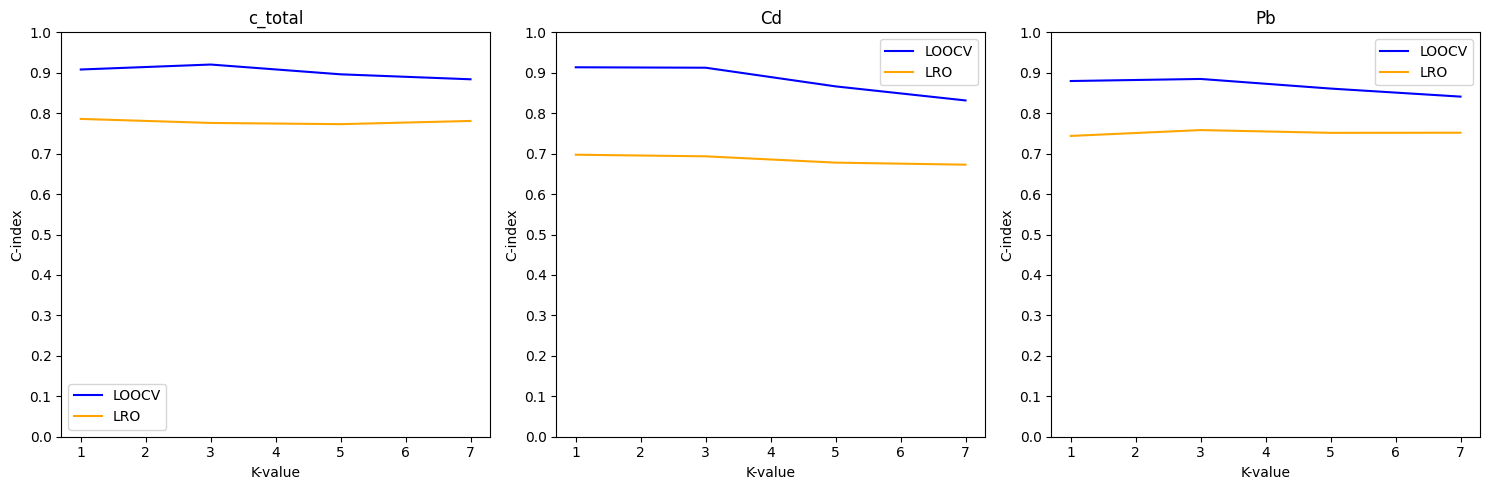

In [81]:
# Convert results_dict to a df for plotting
results_df = pd.DataFrame(results_dict)

num_rows = 1
num_cols = 3

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5))

# Iterate over each variable and plot its c-index values and k-values
for i, target_col in enumerate(y.columns):
    target_df = results_df[results_df['variable'] == target_col]
    ax = axs[i] if num_cols > 1 else axs
    
    # Separate plots for LOOCV and LRO
    loocv_df = target_df[target_df['type'] == 'loocv']
    lro_df = target_df[target_df['type'] == 'lro']
    
    # Plot the LOOCV data
    ax.plot(loocv_df['k'], loocv_df['cindex'], color='blue', label='LOOCV')
    
    # Plot the LRO data
    ax.plot(lro_df['k'], lro_df['cindex'], color='orange', label='LRO')
    
    ax.set_title(target_col)
    ax.set_xlabel("K-value")
    ax.set_ylabel("C-index")
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, step=0.1))
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

## Interpretation of results
#### Answer the following questions based on the results obtained
- Which cross-validation method had more optimistic results? 
- Explain the reason for the optimistic results produced by the cross-validation method.
- Which cross-validation method generalized better on unseen data? Why?

Leave-One-Out had noticably more optimistic C-index results for "unseen" test data compared to Leave-Replicas-Out.
The reason for this is that the dataset had multiple similar datapoints, so when one data point was left out its copies caused overfitting on test data.
Leave-Group-Out in this scenario was better on unseen data, since less information "leaked" from the training process.
